# Preprocesamiento de datos

Con el fin de poder entrenar los diversos modelos de Machine Learning y
Deep learning, es necesário hacer un preprocesamiento de los datos para 
poder obtener un único DataFrame con todas las características necesárias

## Carga de datos

Antes de poder manipular los diferentes datos, primero es necesário
cargarlos en el sistema

In [1]:
import pandas as pd
import polars as pl
import numpy as np 
from pathlib import Path

In [2]:
# Directório de archivos
data_folder = Path("../data/predict-energy-behavior-of-prosumers")

# Diccionario de archivos
files = {
    "train": "train.csv",
    "gas_prices": "gas_prices.csv",
    "client": "client.csv",
    "electricity_prices": "electricity_prices.csv",
    "forecast_weather": "forecast_weather.csv",
    "historical_weather": "historical_weather.csv",
    "county_lon_lats": "county_lon_lats.csv"
}

In [3]:
dfs = {}

for key, filename in files.items():
    filepath = data_folder / filename
    try:
        df = pl.read_csv(filepath)
        dfs[key] = df
        print(f"Archivo {key} cargado con exito.")
    except:
        print(f"No pudo cargarse el archivo {key}.")
    

Archivo train cargado con exito.
Archivo gas_prices cargado con exito.
Archivo client cargado con exito.
Archivo electricity_prices cargado con exito.
Archivo forecast_weather cargado con exito.
Archivo historical_weather cargado con exito.
Archivo county_lon_lats cargado con exito.


## Asignación de longitud/latitud a un condado especifico

Con el fin de poder unir los csv de "train.csv" y "forecast_weather.csv"
es necesario poder asignar a cada longitud y latitud, su condado
correspondiente.

Para ello se utilizará el archivo "county_lon_lats" obtenido de la página
de [kaggle](https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data)
con datos que asignan latitudes y longitudes a su correspondiente condado.

### Visualización de los datos

In [4]:
import matplotlib.pyplot as plt

In [5]:
dfs["county_lon_lats"] = dfs["county_lon_lats"].drop("")
dfs["county_lon_lats"].head()

county,longitude,latitude
i64,f64,f64
0,24.2,59.1
0,25.2,59.1
0,23.7,59.4
0,24.2,59.4
0,24.7,59.4


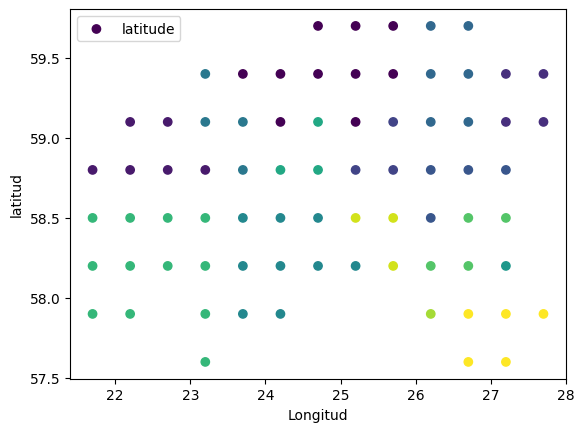

In [6]:
plt.scatter('longitude', 'latitude', c='county', data=dfs["county_lon_lats"])
plt.xlabel("Longitud")
plt.ylabel("latitud")
plt.legend()
plt.show()

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings("ignore")

In [8]:
# Se preparan los datos de entrenamiento y prueba
skf = StratifiedKFold(10, shuffle=True)

# obtención de X e y
X = dfs["county_lon_lats"].drop("county")
y = dfs["county_lon_lats"]["county"].to_numpy()

# Escalado de X para entrenamiento del modelo
scaler = MinMaxScaler()
X_scl = scaler.fit_transform(X)

# Número de clusters o regiones
n_clusters = np.arange(start=1, stop=16)
n_neighbors = np.arange(start=1, step=2, stop=21)

### KNN

In [9]:
train_scores = np.array([])
test_scores = np.array([])

for i in n_neighbors:
    fold_train_scores = np.array([])
    fold_test_scores = np.array([])

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(X_train, y_train)

        fold_train_scores = np.append(
            fold_train_scores,
            knn.score(X_train, y_train)
        )

        fold_test_scores = np.append(
            fold_test_scores,
            knn.score(X_test, y_test)
        )
    
    train_scores = np.append(train_scores, fold_train_scores.mean())
    test_scores = np.append(test_scores, fold_test_scores.mean())

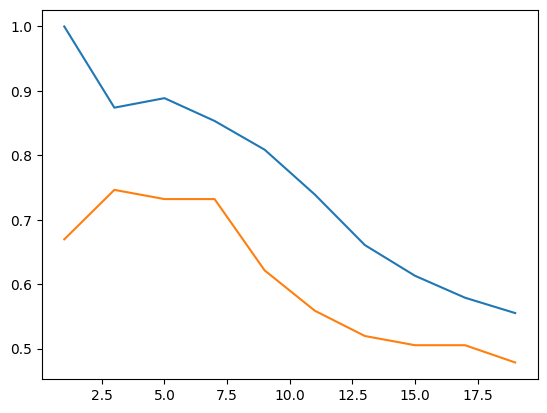

In [10]:
plt.plot(n_neighbors, train_scores)
plt.plot(n_neighbors, test_scores)
plt.show()

### SVC con capa oculta RBF
Este modelo utiliza KMeans para obtener los centroides de los clusters y 
calcular una función RBF la cual se meterá a una SVM con kernel polinómico

In [11]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from statistics import mode

#### Clases

In [12]:
# Calcula y agrupa los datos en clusters utilizando la moda
class kmedias_moda:
    def __init__(self, n_clusters) -> None:
        self.k = n_clusters
        self.moda = -1 * np.ones(self.k, dtype=int)

    def fit(self, X, y):
        self.model = KMeans(self.k)
        self.model.fit(X)

        for i in range(self.k):
            self.moda[i] = mode(y[self.model.labels_ == i])
    
    def predict(self, X):
        return self.moda[self.model.predict(X)]
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [13]:
class oculta_rbf:
    '''
    Calcula los centroides de un modelo Kmeans al cual se le 
    aplica una función RBF utilizando la distancia entre los centroides
    '''

    def __init__(self, n_clusters) -> None:
        self.k = n_clusters
    
    def fit(self, X):
        self.kmeans = KMeans(self.k)
        self.kmeans.fit(X)

        self.centers = self.kmeans.cluster_centers_
        dist = euclidean_distances(X, self.centers)
        self.sigma = np.sum(dist, axis=0)/(dist.shape[0] - 1)
    
    def predict(self, X):
        return np.exp(
            (-euclidean_distances(X, self.centers)**2)/(
                2.0*(self.sigma**2)
            )
        )

#### Obtención de k_optim
Se calcula el número óptimo de clusters que debe tener KMeans
para poder maximizar el resultado de la capa oculta con RBF

In [14]:
train_scores = np.array([])
test_scores = np.array([])

for i in n_clusters:
    fold_train_scores = np.array([])
    fold_test_scores = np.array([])

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X_scl[train_idx], X_scl[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = kmedias_moda(i)
        model.fit(X_train, y_train)

        fold_train_scores = np.append(
            fold_train_scores,
            model.score(X_train, y_train)
        )

        fold_test_scores = np.append(
            fold_test_scores,
            model.score(X_test, y_test)
        )
    
    train_scores = np.append(train_scores, fold_train_scores.mean())
    test_scores = np.append(test_scores, fold_test_scores.mean())

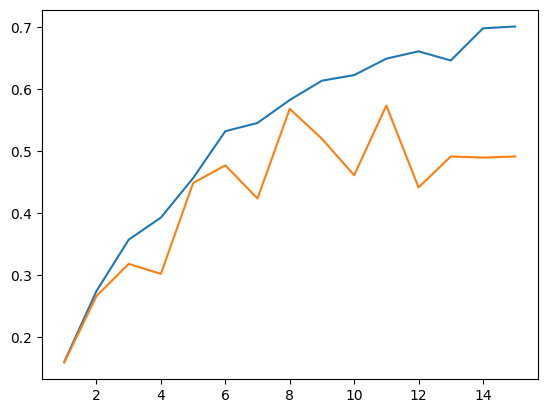

In [15]:
plt.plot(n_clusters, train_scores)
plt.plot(n_clusters, test_scores)
plt.show()

In [16]:
k_optim = n_clusters[test_scores == test_scores.max()].item()
score = test_scores.max()
print(f"k_optim: {k_optim}\nscore: {score}")

k_optim: 11
score: 0.5732142857142857


#### Cálculo del grado óptimo
Se calcula el grádo óptimo del kernel polinómico de la SVM 
para maximizar el resultado.

In [17]:
grados = np.arange(start=2, stop=10)
train_scores = np.array([])
test_scores = np.array([])

for i in grados:
    fold_train_scores = np.array([])
    fold_test_scores = np.array([])

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X_scl[train_idx], X_scl[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Capa oculta RFB
        model = oculta_rbf(k_optim)
        model.fit(X_train)

        # SVM
        svm = SVC(kernel='poly', degree=i)
        svm.fit(model.predict(X_train), y_train)

        fold_train_scores = np.append(
            fold_train_scores,
            svm.score(model.predict(X_train), y_train)
        )

        fold_test_scores = np.append(
            fold_test_scores,
            svm.score(model.predict(X_test), y_test)
        )
    
    train_scores = np.append(train_scores, fold_train_scores.mean())
    test_scores = np.append(test_scores, fold_test_scores.mean())

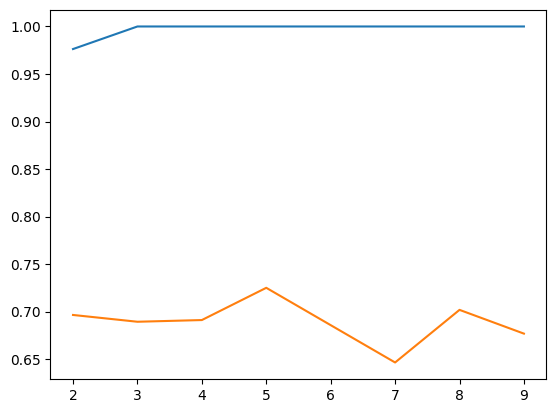

In [18]:
plt.plot(grados, train_scores)
plt.plot(grados, test_scores)
plt.show()

In [19]:
grad_optim = grados[test_scores == test_scores.max()].item()
score = test_scores.max()
print(f"grad_optim: {grad_optim}\nscore: {score}")

grad_optim: 5
score: 0.725


In [20]:
class RBF_SVM:
    def __init__(self, n_clusters:int, degree:int):
        self.oculta = oculta_rbf(n_clusters)
        self.svm = SVC(kernel='poly', degree=degree) 
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        self.oculta.fit(X)
        self.svm.fit(self.oculta.predict(X), y)

    def predict(self, X):
        X = self.scaler.transform(X)
        return self.svm.predict(self.oculta.predict(X))

In [21]:
def add_county(df: pl.DataFrame, model):
    coords = df.select(pl.col("longitude", "latitude"))
    countys = model.predict(coords)

    return df.with_columns(pl.Series("county", countys))

In [22]:
model = RBF_SVM(n_clusters=k_optim, degree=grad_optim)
model.fit(X, y)

dfs["historical_weather"] = add_county(
    dfs["historical_weather"],
    model
)

dfs["forecast_weather"] = add_county(
    dfs["historical_weather"],
    model
)

In [23]:
dfs["train"].dtypes, dfs["train"].columns

([Int64, Int64, Int64, Float64, Int64, String, Int64, Int64, Int64],
 ['county',
  'is_business',
  'product_type',
  'target',
  'is_consumption',
  'datetime',
  'data_block_id',
  'row_id',
  'prediction_unit_id'])

In [24]:
def cast_dataframe(df: pl.DataFrame):
    
    for col in df.columns:
        column = df[col]
        col_dtype = column.dtype

        if col_dtype == pl.Int64 or col_dtype == pl.Int32 or col_dtype == pl.Int16:

            min_val, max_val = column.min(), column.max()

            if np.iinfo(np.int8).min <= min_val <= max_val <= np.iinfo(np.int8).max:
                new_type = pl.Int8
            elif np.iinfo(np.int16).min <= min_val <= max_val <= np.iinfo(np.int16).max:
                new_type = pl.Int16
            elif np.iinfo(np.int32).min <= min_val <= max_val <= np.iinfo(np.int32).max:
                new_type = pl.Int32
            else:
                new_type = pl.Int64

            df = df.with_columns(pl.col(col).cast(new_type))
        
        elif col_dtype == pl.Float64:

            min_val, max_val = column.min(), column.max()

            if np.finfo(np.float32).min <= min_val <= max_val <= np.finfo(np.float32).max:
                new_type = pl.Float32
            else:
                new_type = pl.Float64
            
            df = df.with_columns(pl.col(col).cast(new_type))
        
    return df


In [25]:
# Se realiza un cast a los tipos de las columnas
# para reducir el coste computacional de los merge
for key in dfs.keys():
    dfs[key] = cast_dataframe(dfs[key])

# Unión de DataFrames

In [28]:
ep_df = dfs["electricity_prices"].rename({"forecast_date": "datetime"}).drop(["origin_date"])
final_data = dfs["train"].drop(["row_id"]).join(
    ep_df,
    how="left",
    on=["data_block_id", "datetime"]
)
final_data.columns, dfs["train"].columns, dfs["electricity_prices"].columns

(['county',
  'is_business',
  'product_type',
  'target',
  'is_consumption',
  'datetime',
  'data_block_id',
  'prediction_unit_id',
  'euros_per_mwh'],
 ['county',
  'is_business',
  'product_type',
  'target',
  'is_consumption',
  'datetime',
  'data_block_id',
  'row_id',
  'prediction_unit_id'],
 ['forecast_date', 'euros_per_mwh', 'origin_date', 'data_block_id'])

In [26]:
# train - electricity_prices
ep_df = dfs["electricity_prices"].rename({"forecast_date": "datetime"}).drop(["origin_date"])
final_data = dfs["train"].drop(["row_id"]).join(
    ep_df,
    how="left",
    on=["data_block_id", "datetime"]
)

# Final - historical_weather
hw_df = dfs["historical_weather"].drop(["latitude", "longitude"])
final_data = final_data.join(
    hw_df,
    how="left",
    on=["datetime", "county"]
)

In [27]:
final_data

county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,euros_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id_right
i8,i8,i8,f32,i8,str,i16,i8,f32,f32,f32,f32,f32,f32,i8,i8,i8,i8,f32,i16,f32,f32,f32,f32
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,13.5,10.5,0.0,0.0,1009.5,46,49,0,7,4.416667,347,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,12.6,10.5,0.0,0.0,1004.799988,90,98,3,0,2.861111,324,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,14.0,10.7,0.0,0.0,1014.400024,20,17,1,14,6.75,352,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,14.6,10.6,0.0,0.0,1013.400024,20,17,1,14,6.75,352,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,14.2,10.4,0.0,0.0,1010.200012,34,37,1,2,6.055555,347,0.0,0.0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15,1,0,197.233002,1,"""2023-05-31 23:00:00""",637,64,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
15,1,1,0.0,0,"""2023-05-31 23:00:00""",637,59,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
15,1,1,28.403999,1,"""2023-05-31 23:00:00""",637,59,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [31]:
final_data.shape

(15933928, 24)

In [30]:
2018352 + 15286 +1710802

3744440

In [27]:
vdf = pl.DataFrame()

In [29]:
vdf = vdf.join(pl.DataFrame({"a":[1,2,3], "b":[4,5,6]}), on="a", how="inner")
vdf

ColumnNotFoundError: "a" not found